<a href="https://colab.research.google.com/github/martintmv-git/RB-IBDM/blob/main/Experiments/Generating%20Masks%20with%20SAM/sam_floral_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything by Meta AI
### Generating object masks with SAM for RB-IBDM and saving them in Google Drive

## Before starting

Make sure you are connected to a GPU.

In [1]:
!nvidia-smi

Mon Mar 25 19:03:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and dependencies

In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


### Download SAM weights

In [5]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Insect Data

In [7]:
!mkdir -p {HOME}/data

!wget -q 'link-to-img' -P {HOME}/data

## Load Model

In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
import os

IMAGE_NAME = "/content/flower-day-1.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [12]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [13]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

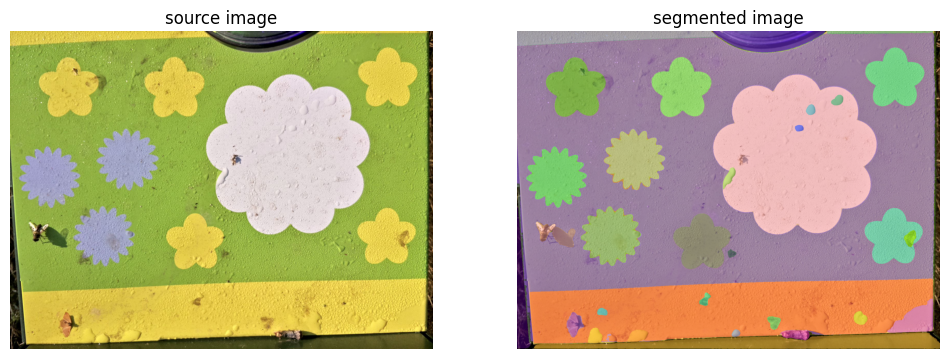

In [14]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

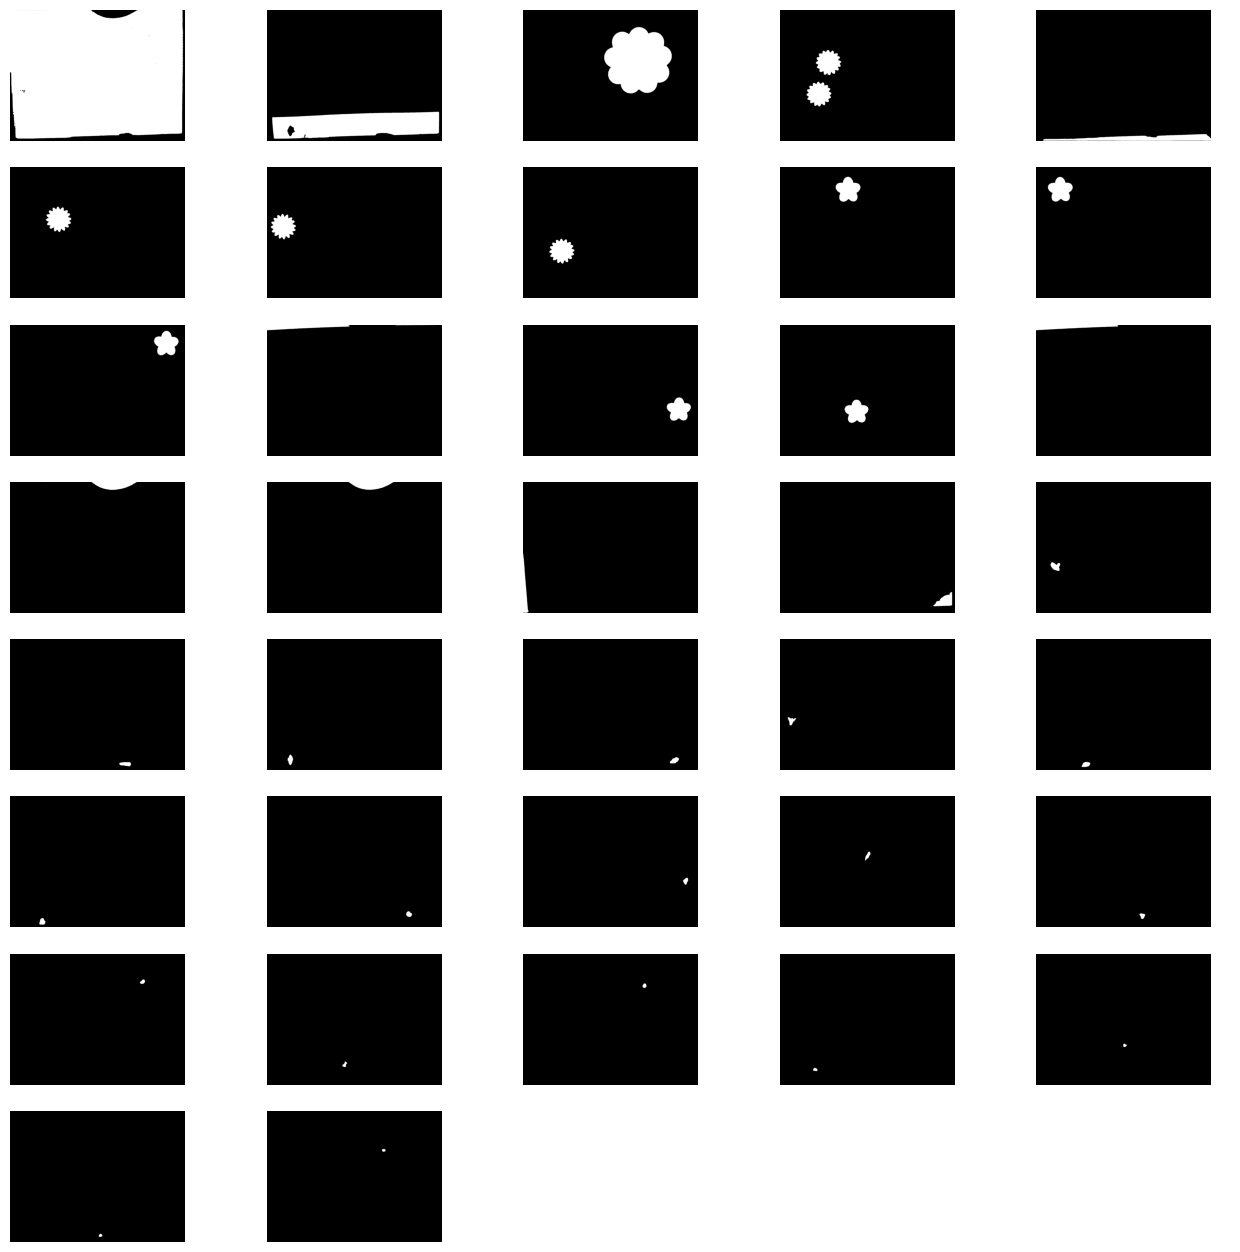

In [15]:
import math

masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

# Calculate the number of rows needed, rounding up to ensure enough space
num_rows = math.ceil(len(masks) / 8)

sv.plot_images_grid(
    images=masks,
    grid_size=(8, num_rows),  # use num_rows here
    size=(16, 16)
)

### Save mask results to Google Drive

In [16]:
from google.colab import drive
drive.mount('/content/drive')
import os

# Path to save my masks
folder_path = '/content/drive/My Drive/diopsis_masks/floral_dataset'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created")
else:
    print(f"Folder '{folder_path}' already exists")

Mounted at /content/drive
Folder '/content/drive/My Drive/diopsis_masks/floral_dataset' created


In [17]:
from PIL import Image
import numpy as np

def save_masks_to_drive(masks, folder_path):
    for i, mask in enumerate(masks):
        # Masks are numpy arrays so convert them to PIL images
        img = Image.fromarray((mask * 255).astype(np.uint8))

        file_path = os.path.join(folder_path, f'mask_{i}.png')
        img.save(file_path)
        print(f'Saved: {file_path}')

save_masks_to_drive(masks, folder_path)

Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_0.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_1.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_2.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_3.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_4.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_5.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_6.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_7.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_8.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_9.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_10.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_11.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_12.png
Saved: /content/drive/My Drive/diopsis_masks/floral_dataset/mask_13.png
Sa